In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function
import math
import keras

In [204]:
(_, _), (x_test, y_test) = keras.datasets.mnist.load_data()

Load a model or create a new one?

In [205]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [206]:
X_train = np.load(f'outputs/x_train_current_{60000}.npy')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
X_train = X_train[:,:,-1]
X_train.shape

(60000, 28)

In [207]:
y_values= np.load(f'outputs/y_train_{60000}.npy')
y_train= np.zeros((y_values.shape[0], 10))
for i in range(y_values.shape[0]):
    y_train[i,y_values[i]]=1
y_train.shape

(60000, 10)

In [208]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [209]:
import keras

import tensorflow.keras.backend as K



def create_nn(dropout_rate=0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 10
    number_of_layers = 3
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'relu')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(10, activation = 'sigmoid')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="number_classifier")

In [210]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "number_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28)]              0         
                                                                 
 dense_229 (Dense)           (None, 10)                290       
                                                                 
 dense_230 (Dense)           (None, 10)                110       
                                                                 
 dense_231 (Dense)           (None, 10)                110       
                                                                 
 dense_232 (Dense)           (None, 10)                110       
                                                                 
Total params: 620 (2.42 KB)
Trainable params: 620 (2.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [211]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='binary_crossentropy'#'mse'
                  )
    


number_of_epochs = 1000




earlystopper = keras.callbacks.EarlyStopping(monitor="loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=50, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [212]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=number_of_epochs,
                    #validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/1000
59/59 - 0s - loss: 0.6425 - lr: 0.0010 - 429ms/epoch - 7ms/step
Epoch 2/1000
59/59 - 0s - loss: 0.4475 - lr: 0.0010 - 50ms/epoch - 847us/step
Epoch 3/1000
59/59 - 0s - loss: 0.2983 - lr: 0.0010 - 48ms/epoch - 822us/step
Epoch 4/1000
59/59 - 0s - loss: 0.2546 - lr: 0.0010 - 51ms/epoch - 866us/step
Epoch 5/1000
59/59 - 0s - loss: 0.2305 - lr: 0.0010 - 48ms/epoch - 809us/step
Epoch 6/1000
59/59 - 0s - loss: 0.2133 - lr: 0.0010 - 36ms/epoch - 608us/step
Epoch 7/1000
59/59 - 0s - loss: 0.1977 - lr: 0.0010 - 48ms/epoch - 821us/step
Epoch 8/1000
59/59 - 0s - loss: 0.1842 - lr: 0.0010 - 54ms/epoch - 918us/step
Epoch 9/1000
59/59 - 0s - loss: 0.1753 - lr: 0.0010 - 46ms/epoch - 774us/step
Epoch 10/1000
59/59 - 0s - loss: 0.1694 - lr: 0.0010 - 37ms/epoch - 635us/step
Epoch 11/1000
59/59 - 0s - loss: 0.1652 - lr: 0.0010 - 65ms/epoch - 1ms/step
Epoch 12/1000
59/59 - 0s - loss: 0.1618 - lr: 0.0010 - 35ms/epoch - 599us/step
Epoch 13/1000
59/59 - 0s - loss: 0.1589 - lr: 0.0010 - 51ms/epoc

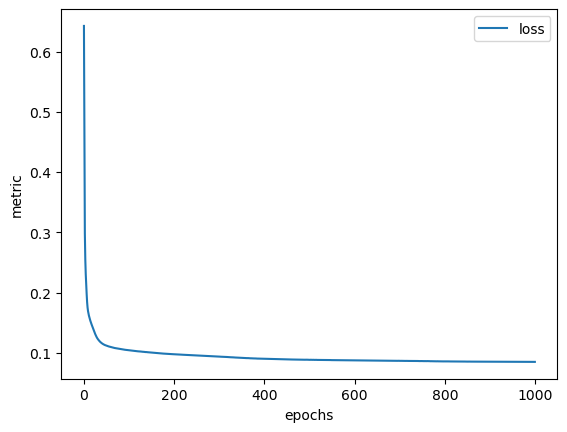

In [213]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss'
                    #    , 'val_loss'
                       ]
                       ,0)

In [214]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

In [215]:
# make prediction on test data
y_train_prediction = model.predict(X_train)
# y_test_prediction = model.predict(x_test)

1875/1875 [==============================] - 1s 452us/step


In [216]:
prediction_count = np.zeros((10,10))
for i in range(y_train_prediction.shape[0]):
    prediction_count[y_values[i], np.argmax(y_train_prediction[i])] +=1

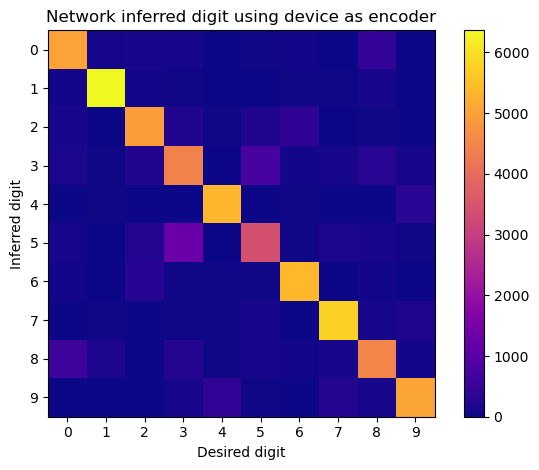

In [219]:
plt.imshow(prediction_count, cmap='plasma')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Network inferred digit using device as encoder')
plt.ylabel('Inferred digit')
plt.xlabel('Desired digit')
plt.tight_layout()
plt.show()